# Summer School

Inspiration for this tutorial was drawn from 

- [Sprague and Czischek, 2024](https://www.nature.com/articles/s42005-024-01584-y)
- [Zhang and Ventra, 2023](https://physics.paperswithcode.com/paper/transformer-quantum-state-a-multi-purpose)
- [Hibat-Allah et. al., 2020](https://journals.aps.org/prresearch/pdf/10.1103/PhysRevResearch.2.023358)
- [Deep Learning Cookbook](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial6/Transformers_and_MHAttention.html)

You can consult the links for further knowledge.

## Using Neural Networks and Variational Monte Carlo for Ground State Search

Let us consider the physics of the problem.

- We are looking at a 2D lattice of Rydberg atoms
- We will be using the Ising Model
- We are assuming all-to-all interaction between all lattice sites
- The Hamiltonian is as follows

$$
\begin{equation}
\tilde{H} = - \frac{\Omega}{2} \sum_{i = 1}^N \left( \hat{\sigma}_i^x \right) - \delta \sum_{i = 1}^N \left ( \hat{n}_i \right ) + \sum_{i,j} \left ( V_{ij} \hat{n}_i \hat{n}_j \right )
\end{equation}
$$


where $V_{ij} = \frac{7}{| \textbf{r}_i - \textbf{r}_j |^6}$.

*TO Do*

- change N to Nx for proper identification
- set up the structure of the local energy function and write some to dos for the students to evaluate observables

In [1]:
import os
import sys
import ipywidgets as widgets
from IPython.display import display, HTML

import matplotlib.pyplot as plt

## Setup absolute imports

In [2]:
# Ensure the 'src' directory is in the Python path
project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
src_path = os.path.join(project_root, 'src')

if src_path not in sys.path:
    sys.path.append(src_path)

## Define  Network Prameters

In [3]:
from display_helpers import display_configuration_ui, display_vmc_configuration_ui
from definitions import RNNConfig, TransformerConfig, ModelType, VMCConfig
from models import get_model

In [4]:
model_type_dropdown, rnn_widgets, transformer_widgets = display_configuration_ui()

Dropdown(description='Model Type:', layout=Layout(width='50%'), options=(('RNN', 1), ('TRANSFORMER', 2)), styl…

In [5]:
vmc_widgets = display_vmc_configuration_ui()

In [6]:
# Function to get the selected configuration
def get_selected_configuration():
    selected_model_type = model_type_dropdown.value
    if selected_model_type == ModelType.RNN.value:
        config = RNNConfig(
            output_dim=rnn_widgets['output_dim'].value,
            num_hidden_units=rnn_widgets['num_hidden_units'].value
        )
    elif selected_model_type == ModelType.TRANSFORMER.value:
        config = TransformerConfig(
            num_layers=transformer_widgets['num_layers'].value,
            input_dim=transformer_widgets['input_dim'].value,
            num_heads=transformer_widgets['num_heads'].value,
            dim_feedforward=transformer_widgets['dim_feedforward'].value,
            dropout_prob=transformer_widgets['dropout_prob'].value
        )
    return config


# Function to get the selected VMC configuration
def get_selected_vmc_configuration():
	return VMCConfig(
        nsamples=vmc_widgets['nsamples'].value,
        n=vmc_widgets['n'].value,
        learning_rate=vmc_widgets['learning_rate'].value,
        num_epochs=vmc_widgets['num_epochs'].value,
		output_dim=vmc_widgets['output_dim'].value,
        sequence_length=vmc_widgets['sequence_length'].value,
        num_hidden_units=vmc_widgets['num_hidden_units'].value,
	)

In [7]:
from enum import Enum

class ModelType(Enum):
    RNN = 1
    TRANSFORMER = 2
    
ModelType["RNN"]

<ModelType.RNN: 1>

In [8]:
selected_config = get_selected_configuration()
print(f'Selected Configuration: {selected_config}')

Selected Configuration: RNNConfig(output_dim=2, num_hidden_units=128)


In [9]:
vmc_config = get_selected_vmc_configuration()
print(f'Selected VMC Configuration: {vmc_config}')

Selected VMC Configuration: VMCConfig(nsamples=1000, n=4, learning_rate=0.001, num_epochs=1000, output_dim=2, sequence_length=16, num_hidden_units=128)


## Get Network Model

In [10]:
# get modeltype whose value is 1
model_type = ModelType(1)
model_type

<ModelType.RNN: 1>

In [11]:
model = get_model(ModelType(model_type_dropdown.value))(*selected_config)
# model = ModelType(model_type_dropdown.value)
print(f"{model=}")

model=RNNModel(
    # attributes
    output_dim = 2
    num_hidden_units = 128
)


## Variational Monte Carlo + Neural Quantum State


We will be combining Variational Monte Carlo method with our Neural Quantum State to search for the ground state of our system. Most of the code has been written under the hood but you have to provide the last piece. In this section, you have the task of creating the energy function that  computes the `locaal_energy` of a batch of a batch of  configurations. 

- Create a class that inherites from `VMC`;
- Create an instance method called `local_energy`;
- Its signature is take in the following parameters in order:
	- samples: this is the batch of configurations for which we need to compute  local energies
	- params: these are the network weights 
	- model: this is the network model
	- log_psi: log of psi

In [12]:
from vmc import VMC
from jax import jit, lax, random
from jax import numpy as jnp
from functools import partial
from typing import List, Tuple, Union

In [13]:
class MyVMC(VMC):
	def __init__(self,**kwargs):
		super().__init__(**kwargs)	
            
	def local_energy(self):
		...

my_vmc = MyVMC(**vmc_config._asdict())

In [14]:
class ImplVMC(VMC):
	def __init__(self,**kwargs):
		super().__init__(**kwargs)

	
	def local_energy(self, samples, params, model, log_psi) -> List[float]:
		output = jnp.zeros((samples.shape[0]), dtype=jnp.float32)

		def step_fn_chemical(i, state):
			s, output = state
			output += - self.delta * s[:, i]
			return s, output

		def step_fn_intr(i, state):
			samples, pairs, multipliers, output = state
			output += multipliers[i] * samples[:, pairs[i, 0]] * samples[:, pairs[i, 1]]
			return samples, pairs, multipliers, output


		def step_fn_transverse(i, state):
			s, output = state
			flipped_state = s.at[:, i].set(1 - s[:, i])
			flipped_logpsi = self.logpsi(flipped_state, params, model)
			output += - 0.5 * self.Omega * jnp.exp(flipped_logpsi - log_psi)
			return s, output


    	# Interaction Term
		_, _, _, interaction_term = lax.fori_loop(0, 120, step_fn_intr, (samples, self.pairs, self.multipliers, output))
        # Off Diagonal Term
		_, transverse_field = lax.fori_loop(0, 16, step_fn_transverse, (samples, output))
        # _, transverse_field = lax.fori_loop(0, 16, step_fn_transverse, (samples, output))
        # Occupancy Term
		_, chemical_potential = lax.fori_loop(0, 16, step_fn_chemical, (samples, output))

        # Total energy
		loc_e = transverse_field + chemical_potential + interaction_term
		
		return loc_e


impl_vmc = ImplVMC(**vmc_config._asdict())

## Run the Network

In [15]:
batch_size = 500
output_dim = 2
sequence_length = 16

rng_key = random.PRNGKey(0)
dummy_input = jnp.zeros((batch_size, sequence_length, output_dim))
params = model.init(rng_key, dummy_input)

In [16]:
e_den = impl_vmc.train(rng_key, params, model)

step 0, loss: 8.940939903259277
step 100, loss: -4.06959867477417
step 200, loss: -4.540643215179443
step 300, loss: -3.5262484550476074
step 400, loss: -4.3437652587890625
step 500, loss: -3.4739608764648438
step 600, loss: -3.3683578968048096
step 700, loss: -3.519996404647827
step 800, loss: -4.598249435424805
step 900, loss: -4.18049430847168


In [17]:
den = [(i.mean() / 16).item() for i in e_den]

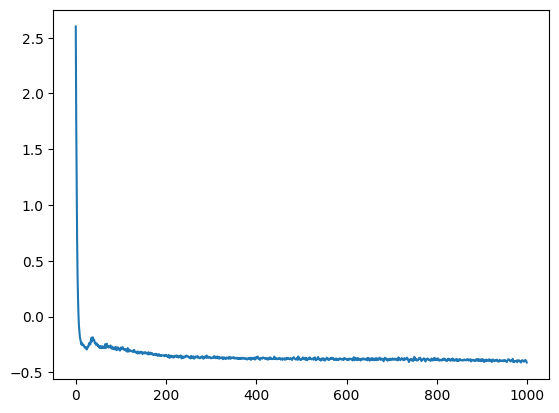

In [18]:
# import matplotlib.pyplot as plt

plt.plot(den)
plt.show()

In [22]:
den[-1]

-0.41152632236480713

In [20]:
# import pandas as pd
# import streamlit as st

In [21]:
# st.line_chart(pd.DataFrame(den))